In [22]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp

In [ ]:

x0 = np.array([-8903.833, 1208.356, 213.066, -0.971, -6.065, -1.069]) # intital condition
meu = 398600 # km^3/s^2
radius = 6378 # km
t0 = 0 # s
tf = 3 * 60 * 60 # hr
t_span = (t0, tf) # s
dt = 0.1 
t_eval = np.arange(t0, tf + dt, dt)

def dyn(t,x):
    xdot = np.zeros(6)
    xdot[0] = x[3]
    xdot[1] = x[4]
    xdot[2] = x[5]
    xdot[3] = (-meu / radius**3) * x[0]
    xdot[4] = (-meu / radius**3) * x[1]
    xdot[5] = (-meu / radius**3) * x[2]
    return xdot

# def rk4(t,x,dt):
#     k1 = dyn(t,x)
#     k2 = dyn(t+dt/2, x+0.5*k1*dt)
#     k3 = dyn(t+dt/2, x+0.5*k2*dt)
#     k4 = dyn(t+dt, x+k3*dt)
#     rnew = x + 1/6 * (k1 + 2*k2 + 2*k3 + k4) * dt
#     return t, rnew

# vals = solve_ivp(dyn, t_span, x0, method='RK45', rtol=1e-13)
# display(vals)



# T = []
# X_rk4 = []
# H_rk4 = []
# x_rk4 = x0



# for t_k, x_k in zip(vals.t, vals.y.T):

#     # Comute Angular Momnetum
#     h_rk4 = np.linalg.norm(np.cross(x_k[0:3], x_k[3:6]))

#     # Store
#     X_rk4.append(np.array(x_k))
#     H_rk4.append(np.array(h_rk4))
#     T.append(np.array(t_k))

#     t = t+dt

# X_rk4 = np.array(X_rk4)
# T = np.array(T)


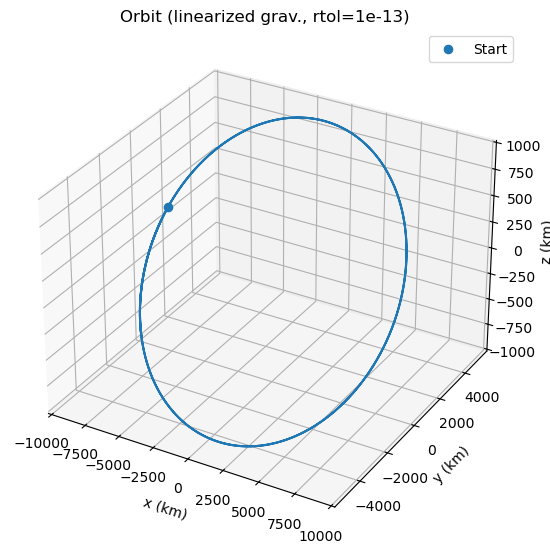

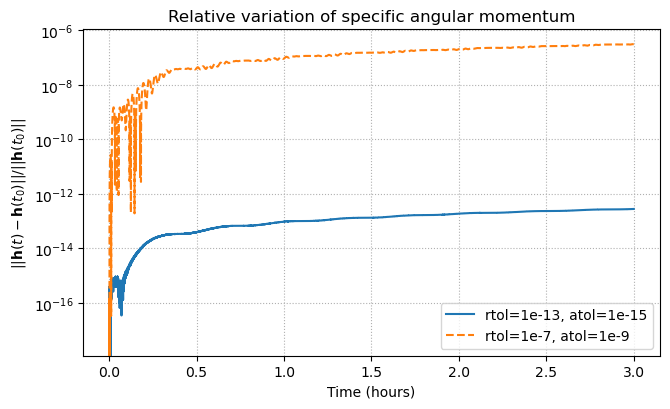

Max relative |h| variation, rtol=1e-13: 2.810e-13
Max relative |h| variation, rtol=1e-7 : 3.116e-07


In [84]:
import matplotlib.pyplot as plt
def run_once(rtol, atol):
    sol = solve_ivp(dyn, t_span, x0, method='RK45', rtol=rtol, atol=atol, t_eval=t_eval)
    T = sol.t                       # (N,)
    X = sol.y.T                     # (N, 6)
    R = X[:, 0:3]                   # (N, 3)
    V = X[:, 3:6]                   # (N, 3)
    H_vec = np.cross(R, V)          # (N, 3)  specific angular momentum vectors
    h0 = H_vec[0]
    rel_var = np.linalg.norm(H_vec - h0, axis=1) / np.linalg.norm(h0)
    return T, R, V, H_vec, rel_var

T_hi, R_hi, V_hi, H_hi, rel_hi = run_once(rtol=1e-13, atol=1e-15)

# b
fig = plt.figure(figsize=(6.6, 5.6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(R_hi[:,0], R_hi[:,1], R_hi[:,2], lw=1.5)
ax.scatter(R_hi[0,0], R_hi[0,1], R_hi[0,2], s=35, label='Start')
ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)'); ax.set_zlabel('z (km)')
ax.set_title('Orbit (linearized grav., rtol=1e-13)')
ax.legend()
plt.tight_layout()

# c
plt.figure(figsize=(6.8, 4.2))
plt.semilogy(T_hi/3600, rel_hi, label='rtol=1e-13, atol=1e-15')
plt.xlabel('Time (hours)')
plt.ylabel(r'$||\mathbf{h}(t)-\mathbf{h}(t_0)||/||\mathbf{h}(t_0)||$')
plt.title('Relative variation of specific angular momentum')
plt.grid(True, which='both', ls=':')

# Loose tolerance
T_lo, R_lo, V_lo, H_lo, rel_lo = run_once(rtol=1e-7, atol=1e-9)
plt.semilogy(T_lo/3600, rel_lo, '--', label='rtol=1e-7, atol=1e-9')
plt.legend()
plt.tight_layout()
plt.show()

# d and e
print(f"Max relative |h| variation, rtol=1e-13: {rel_hi.max():.3e}")
print(f"Max relative |h| variation, rtol=1e-7 : {rel_lo.max():.3e}")

## D
Based on the computation done in part c, the quantity is conserved because $\Delta |H|$ appoaches a computational zero value since $10^{-13}$ is basically zero

## E
Based on the computation done in part c, the decrease in relative tolerance caused the $\Delta |H|$ to increase. Given the exact solution has $\Delta |H| = 0$, the $\Delta |H|$ increase shows that the quanity is less conserved then with the higher tolerance. In both cases the quantity is conserved because $\Delta |H|$ appoaches a computational zero value since $10^{-6}$ is basically zero

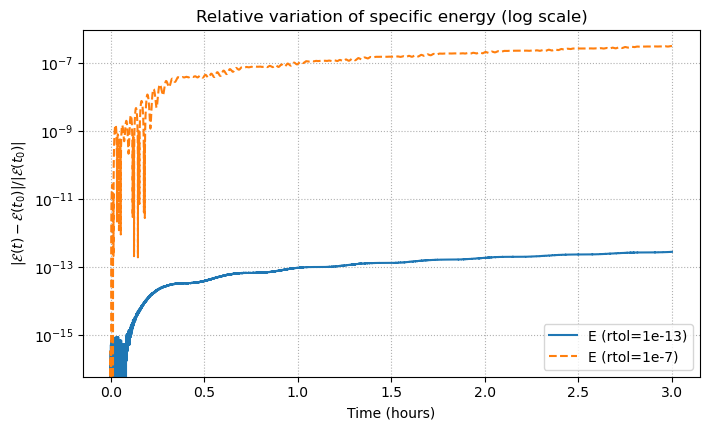

Max rel variation E_linear(rtol=1e-13): 2.806e-13
Max rel variation E_linear(rtol=1e-7 ): 3.116e-07


In [88]:
def run_once(rtol, atol):
    sol = solve_ivp(dyn, t_span, x0, method='RK45', rtol=rtol, atol=atol, t_eval=t_eval)
    T = sol.t
    X = sol.y.T
    R = X[:, 0:3]
    V = X[:, 3:6]
    H_vec = np.cross(R, V)

    # ---- Energies ----
    rnorm = np.linalg.norm(R, axis=1)
    v2 = np.sum(V*V, axis=1)

    E_true = 0.5*v2 - meu/rnorm

    omega2 = meu / radius**3
    E_lin = 0.5*v2 + 0.5*omega2*(rnorm**2)

    # relative variations
    rel_true = np.abs(E_true - E_true[0]) / np.abs(E_true[0])
    rel_lin  = np.abs(E_lin  - E_lin[0])  / np.abs(E_lin[0])

    return T, R, V, H_vec, E_true, E_lin, rel_true, rel_lin


T_hi, R_hi, V_hi, H_hi, Etrue_hi, Elin_hi, rel_true_hi, rel_lin_hi = run_once(1e-13, 1e-15)


plt.figure(figsize=(7.2, 4.4))
# plt.semilogy(T_hi/3600, rel_true_hi, label='E_true (rtol=1e-13)')
plt.semilogy(T_hi/3600, rel_lin_hi,  label='E (rtol=1e-13)')
plt.xlabel('Time (hours)')
plt.ylabel(r'$|\mathcal{E}(t)-\mathcal{E}(t_0)|/|\mathcal{E}(t_0)|$')
plt.title('Relative variation of specific energy (log scale)')
plt.grid(True, which='both', ls=':')

T_lo, R_lo, V_lo, H_lo, Etrue_lo, Elin_lo, rel_true_lo, rel_lin_lo = run_once(1e-7, 1e-9)
# plt.semilogy(T_lo/3600, rel_true_lo, '--', label='E_true (rtol=1e-7)')
plt.semilogy(T_lo/3600, rel_lin_lo,  '--', label='E (rtol=1e-7)')
plt.legend()
plt.tight_layout()
plt.show()

# g and h
# print(f"Max rel variation E_true  (rtol=1e-13): {rel_true_hi.max():.3e}")
print(f"Max rel variation E_linear(rtol=1e-13): {rel_lin_hi.max():.3e}")
# print(f"Max rel variation E_true  (rtol=1e-7 ): {rel_true_lo.max():.3e}")
print(f"Max rel variation E_linear(rtol=1e-7 ): {rel_lin_lo.max():.3e}")

## G

Based on the plots in part f, the Energy is also conserved as $\Delta E \approx 0$ since $10^{-11}$ is ostensably zero

## H

Much like $\Delta |H|$ in part e, $\Delta E \approx 0$ as $10^{-6}$ is ostensably zero